In [1]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import ast

from scipy.stats import spearmanr, pearsonr

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def load_data(data_files, drop_cols=['Preamble'], convert_prob=True):
    return_df = pd.DataFrame()
    for data_file in data_files:
        data = pd.read_csv(data_file)
        data = data.drop(drop_cols, axis=1)

        try:
            data['stimulus_prob'] = [[t for t in m] for m in data['stimulus_prob'].apply(ast.literal_eval)]
        except ValueError as e:
            for m in data['stimulus_prob']:
                print(m)
            print(data['stimulus_prob'])
            return None
        
        if convert_prob:
            data['stimulus_prob'] = [[(2 ** t) for t in m] for m in data['stimulus_prob']]

        return_df = pd.concat([return_df, data], ignore_index=True)

    return return_df

In [13]:
def plot_by_dataset_truecat_fantype(df_and_sol, df_and_mist,
                                    abs_min_sol  = 0, abs_max_sol  = 1,
                                    prs_min_sol  = 0, prs_max_sol  = 1,
                                    abs_min_mist = 0, abs_max_mist = 1,
                                    prs_min_mist = 0, prs_max_mist = 1,
                                    jit = 0):
    df_and_sol['Experiment'] = 'SOLAR'
    df_and_sol['stimulus_prob'] = df_and_sol['stimulus_prob'].apply(np.median)
    df_and_sol = df_and_sol.loc[
        (
            (df_and_sol['True_Category'] == 'present')
            &
            (prs_min_sol <= df_and_sol['stimulus_prob']) & (df_and_sol['stimulus_prob'] <= prs_max_sol)
        )
        |
        (
            (df_and_sol['True_Category'] == 'absent')
            &
            (abs_min_sol <= df_and_sol['stimulus_prob']) & (df_and_sol['stimulus_prob'] <= abs_max_sol)
        )

    ]

    df_and_mist['Experiment'] = 'Mistral'
    df_and_mist['stimulus_prob'] = df_and_mist['stimulus_prob'].apply(np.median)
    df_and_mist = df_and_mist.loc[
        (
            (df_and_mist['True_Category'] == 'present')
            &
            (prs_min_mist <= df_and_mist['stimulus_prob']) & (df_and_mist['stimulus_prob'] <= prs_max_mist)
        )
        |
        (
            (df_and_mist['True_Category'] == 'absent')
            &
            (abs_min_mist <= df_and_mist['stimulus_prob']) & (df_and_mist['stimulus_prob'] <= abs_max_mist)
        )

    ]

    full_df = pd.concat(
        [
            df_and_sol.loc[df_and_sol['Dependent_Variable'] == df_and_sol['True_Category']],
            df_and_mist.loc[df_and_mist['Dependent_Variable'] == df_and_mist['True_Category']],
        ]
    )

    fan_person = full_df.copy()
    fan_person['fan'] = fan_person['Fan_Person']
    fan_person['fan_type'] = 'person'

    fan_place = full_df.copy()
    fan_place['fan'] = fan_place['Fan_Place']
    fan_place['fan_type'] = 'place'

    full_df = pd.concat([fan_person, fan_place])

    for exp in ['SOLAR', 'Mistral']:
        for cat in ['absent', 'present']:
            for ft in ['person', 'place']:
                print(f'{exp}-{cat}-{ft}')
                df_subset = full_df[(full_df['Experiment'] == exp) & (full_df['True_Category'] == cat) & (full_df['fan_type'] == ft)]
                z = spearmanr(df_subset['fan'].tolist(), df_subset['stimulus_prob'].tolist())
                print(f'\tSpearman r = {z.statistic:.3f}, p = {z.pvalue:.3f}')
                z = pearsonr(df_subset['fan'].tolist(), df_subset['stimulus_prob'].tolist())
                print(f'\tPearson r = {z.statistic:.3f}, p = {z.pvalue:.3f}')

    full_df = full_df.rename(
        columns={
            'True_Category' : 'Canary',
            'fan_type'      : 'Fan Type',
            'stimulus_prob' : 'Token Probability',
            'fan'           : 'Fan Value'
        }
    )

    # [hue, col, row]
    dims = [
        'Fan Type',
        'Experiment',
        'Canary',
    ]

    max_fan = full_df['Fan Value'].max()

    def alt_bands(ax=None, highlight = None):
        ax = ax or plt.gca()
        x_left, x_right = ax.get_xlim()
        locs = ax.get_xticks()
        count = 0
        for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
            if count == highlight:
                ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
            else:
                ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
            count += 1
        ax.set_xlim(x_left, x_right)

    g = sns.FacetGrid(full_df.iloc[:,:],
                      col=dims[1], row=dims[2],
                      sharex='col', sharey=True,
                      margin_titles=True,
                      height=3.5,
                      aspect=1,
                    #   facet_kws=dict(sharex=False),
                      gridspec_kws=dict(width_ratios=[1, 1], height_ratios=[1,1]))
    g.set_axis_labels(x_var='Fan Value', y='Token Probability', clear_inner=False)
    g.map_dataframe(sns.swarmplot, x='Fan Value', y='Token Probability', hue=dims[0], dodge=True, size=2.5, palette="Set1", legend=True)
    g.add_legend(bbox_to_anchor=(0.8,0.9), frameon=True, title='Fan Type', fontsize=12, title_fontsize=16)

    color1, color2 = sns.color_palette('Set1')[:2]

    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'person') &
                            (full_df['Experiment'] == 'SOLAR') &
                            (full_df['Canary'] == 'absent')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color1), truncate=False,
                ax=g.axes[0][0])
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'place') &
                            (full_df['Experiment'] == 'SOLAR') &
                            (full_df['Canary'] == 'absent')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color2), truncate=False,
                ax=g.axes[0][0])
    
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'person') &
                            (full_df['Experiment'] == 'Mistral') &
                            (full_df['Canary'] == 'absent')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color1), truncate=False,
                ax=g.axes[0][1])
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'place') &
                            (full_df['Experiment'] == 'Mistral') &
                            (full_df['Canary'] == 'absent')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color2), truncate=False,
                ax=g.axes[0][1])
    
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'person') &
                            (full_df['Experiment'] == 'SOLAR') &
                            (full_df['Canary'] == 'present')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color1), truncate=False,
                ax=g.axes[1][0])
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'place') &
                            (full_df['Experiment'] == 'SOLAR') &
                            (full_df['Canary'] == 'present')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color2), truncate=False,
                ax=g.axes[1][0])

    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'person') &
                            (full_df['Experiment'] == 'Mistral') &
                            (full_df['Canary'] == 'present')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color1), truncate=False,
                ax=g.axes[1][1])
    sns.regplot(full_df.loc[(full_df['Fan Type'] == 'place') &
                            (full_df['Experiment'] == 'Mistral') &
                            (full_df['Canary'] == 'present')],
                x='Fan Value', y='Token Probability',
                scatter=False, line_kws=dict(color=color2), truncate=False,
                ax=g.axes[1][1])
    
    # for margin_title in g._margin_titles_texts:
    #     margin_title.set_fontsize(12)

    # g.set_titles()
    g.set_titles(row_template='{row_name}', col_template='{col_name}', size=14)

    g.axes[1][0].set_xlabel('')
    g.axes[1][1].set_xlabel('Fan Value                                               ', size=14)#, loc='left')

    g.axes[0][0].set_ylabel('Token Probability                                                   ', size=14)#, loc='left')
    g.axes[1][0].set_ylabel('')

    g.legend.get_title().set_fontsize(14)

    g.figure.suptitle('In-Context Fan vs. Token Probability', x=0.46, y=1.02, weight='bold', fontsize=16)

    alt_bands(g.axes[0][0], highlight=14)
    alt_bands(g.axes[0][1], highlight=14)
    alt_bands(g.axes[1][0], highlight=14)
    alt_bands(g.axes[1][1], highlight=14)
    plt.show()


SOLAR-absent-person
	Spearman r = -0.196, p = 0.002
	Pearson r = -0.232, p = 0.000
SOLAR-absent-place
	Spearman r = 0.208, p = 0.001
	Pearson r = 0.194, p = 0.002
SOLAR-present-person
	Spearman r = -0.144, p = 0.456
	Pearson r = -0.011, p = 0.953
SOLAR-present-place
	Spearman r = -0.219, p = 0.254
	Pearson r = -0.221, p = 0.250
Mistral-absent-person
	Spearman r = -0.415, p = 0.000
	Pearson r = -0.397, p = 0.000
Mistral-absent-place
	Spearman r = -0.152, p = 0.016
	Pearson r = -0.168, p = 0.008
Mistral-present-person
	Spearman r = 0.482, p = 0.027
	Pearson r = 0.516, p = 0.017
Mistral-present-place
	Spearman r = 0.029, p = 0.900
	Pearson r = 0.060, p = 0.798


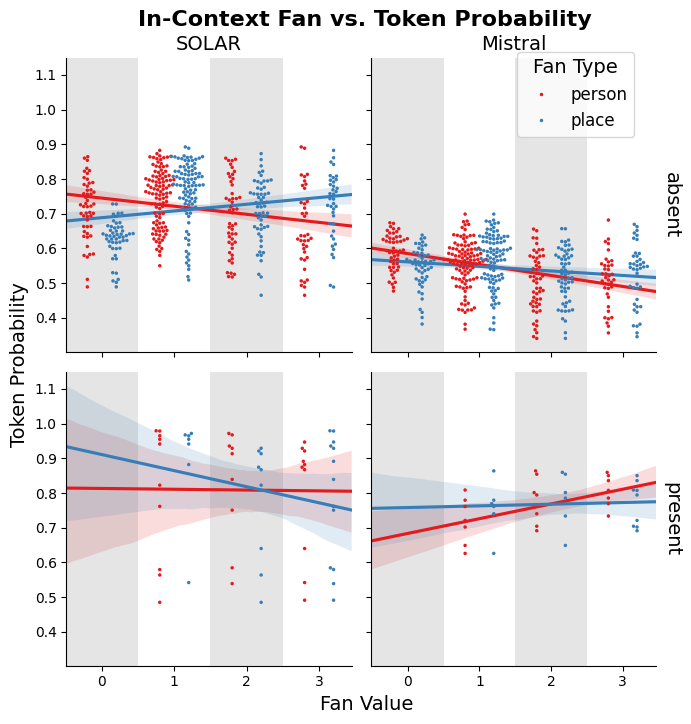

In [14]:
runs_and_sol = [
    '../data/Random/run_0/And_Orig/SOLAR-10-7B_pop50_results.csv',
    '../data/Random/run_1/And_Orig/SOLAR-10-7B_pop50_results.csv',
    '../data/Random/run_2/And_Orig/SOLAR-10-7B_pop50_results.csv',
]
runs_and_mist = [
    '../data/Random/run_0/And_Orig/Mistral-7B_pop50_results.csv',
    '../data/Random/run_1/And_Orig/Mistral-7B_pop50_results.csv',
    '../data/Random/run_2/And_Orig/Mistral-7B_pop50_results.csv',   
]

# Full data (no thresholding)
plot_by_dataset_truecat_fantype(load_data(runs_and_sol),
                                load_data(runs_and_mist),
                                jit = 0.15
)

# Threshold above noise floor
plot_by_dataset_truecat_fantype(load_data(runs_and_sol),
                                load_data(runs_and_mist),
                                jit = 0.15,

                                prs_min_mist=0.4,
                                prs_max_mist=1,
                                abs_min_mist=0.3,
                                abs_max_mist=1,

                                prs_min_sol=0.4,
                                prs_max_sol=1,
                                abs_min_sol=0.45,
                                abs_max_sol=1,
                               )